# Towards SAT Solving for Graph Aggregation
This notebook is based on the notebook for the course on *Computational Social Choice*, demonstrating how to use SAT-solving technology to reason about voting rules, prepared by [Ulle Endriss](https://staff.science.uva.nl/u.endriss/), ILLC, University of Amsterdam (November 2023).

This notebook is part of the implementation of a project extending SAT solving to the graph aggregation domain, as set up by [Endriss & Grandi, 2018](https://dl.acm.org/doi/abs/10.1145/3184558.3186231).

## System Requirements
You need to be able to run [Jupyter Notebooks](https://realpython.com/jupyter-notebook-introduction/) for Python 3 and you need to have the [PySAT](https://pysathq.github.io/) toolkit [installed](https://pysathq.github.io/installation/) on your machine. 

## Imports

In [1]:
from math import factorial
from itertools import permutations
from random import shuffle

In [2]:
from pysat.solvers import Glucose3
from pysat.formula import WCNF
from pysat.examples.musx import MUSX

In [3]:
def solve(cnf):
    solver = Glucose3()
    for clause in cnf: solver.add_clause(clause)
    if solver.solve():
        return solver.get_model()
    else:
        return('UNSATISFIABLE')

The method `enumModels()` can be used to enumerate all satisfying models of a given formula in CNF. Keep in mind that this is a demanding operation and that the number of models can be huge. Note that the object returned by `enumModels()` is an iterator (not a list). A simple way of inspecting it is to use the `list()` method on the object returned by `enumModels()`.

In [5]:
def enumModels(cnf):
    solver = Glucose3()
    for clause in cnf: solver.add_clause(clause)
    return solver.enum_models()

The method `getMUS()` can be used to compute an MUS for a given formula in CNF (which should be unsatisfiable). Note that a given formula might have more than one MUS, and `getMUS()` does not necessarily return the smallest MUS (because computing a cardinality-minimal MUS is a much more demanding operation).

In [7]:
def getMUS(cnf):
    wcnf = WCNF()
    for clause in cnf: wcnf.append(clause, 1)
    mus = MUSX(wcnf,verbosity=0).compute()
    return list(cnf[i-1] for i in mus)

In [10]:
# config, utils, axioms, properties, literals
from config import config
from utils import *
from axioms import *
from properties import *

In [13]:
prop_fns = [cnfIrreflexivity, cnfCompleteness, cnfTransitivity]
graphs = generate_graph_subsets(prop_fns)

# graphs = generate_graph_subsets([cnfIrreflexivity, cnfConnectedness, cnfTransitivity, cnfCompleteness])
config.update_graphs(graphs)

Updating config.graphs
Updating config.g := 6


[(0, 1), (0, 2), (1, 2)]


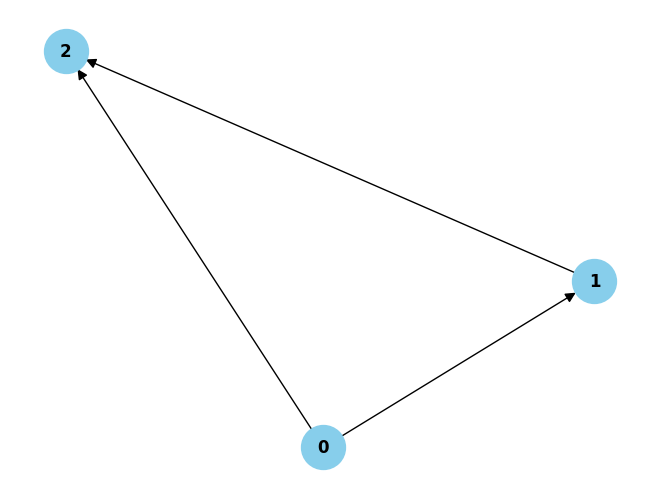

[(0, 2), (1, 0), (1, 2)]


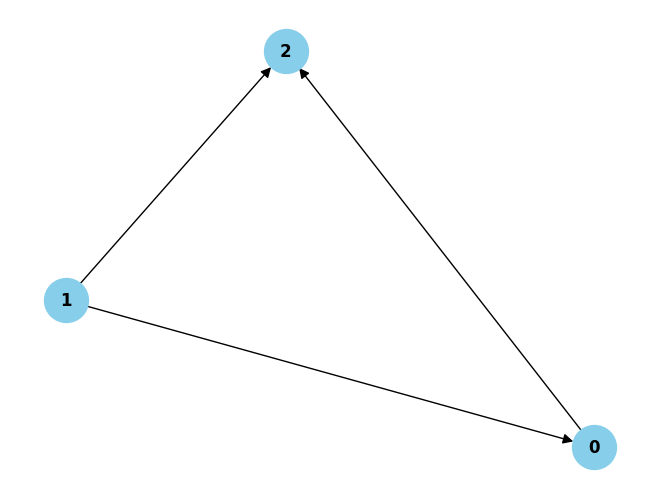

[(1, 0), (1, 2), (2, 0)]


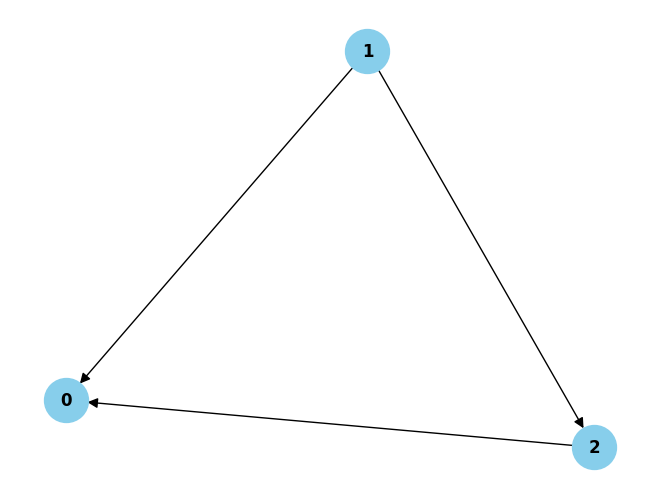

[(0, 1), (0, 2), (2, 1)]


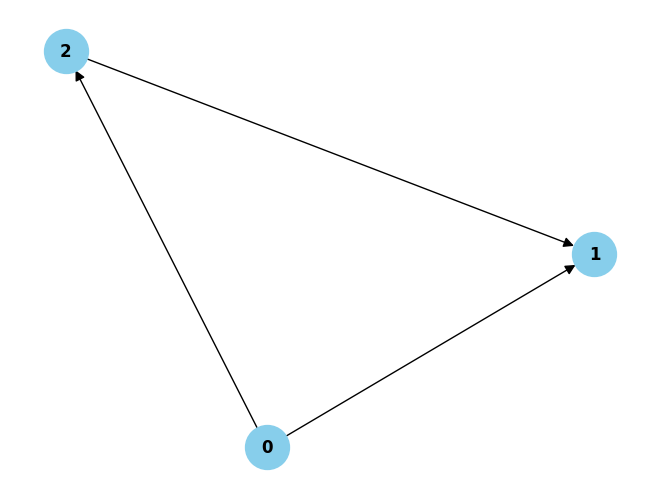

[(0, 1), (2, 0), (2, 1)]


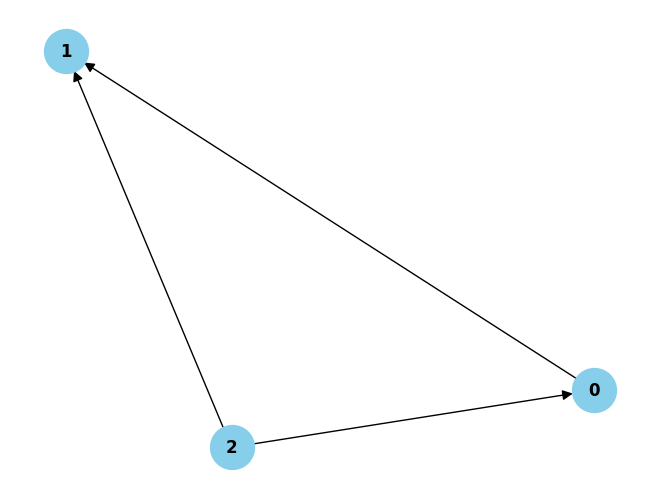

[(1, 0), (2, 0), (2, 1)]


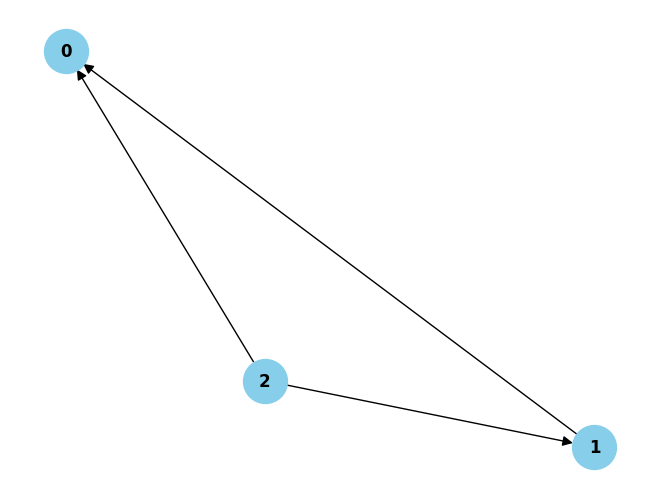

In [14]:
from plot import draw_labeled_graph
for graph in config.graphs:
    edges = get_graph(graph, config.v)
    print(edges)
    draw_labeled_graph(edges, config.v)


In [15]:
from explain import Explain

In [16]:
cr = cr_fn(prop_fns)
arrow_axioms = [iie, nondictatorship, unanimity, grounded, cr]
iie_cnf = iie()
nondict_cnf = nondictatorship()
unanim_cnf = unanimity()
ground_cnf = grounded()
cr_cnf = cr()

ex = Explain(arrow_axioms, prop_fns=prop_fns)


Expected clauses:  839808
Expected clauses:  839808


In [17]:
ex = Explain(arrow_axioms, prop_fns=prop_fns)

cnf = iie_cnf + nondict_cnf + unanim_cnf + ground_cnf + cr_cnf
print("Total clauses:", len(cnf))
full_sol = list(enumModels(cnf))
print("EXISTING MODELS:", len(full_sol))

if len(full_sol) == 0:
    mus = getMUS(cnf)
    print(ex(mus))

Expected clauses:  839808
Total clauses: 463647
EXISTING MODELS: 0
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (0,1) or 
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
194: [(0, 1), (2, 0), (2, 1)]
-> (0,1)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (1,2) or 
38: [(0, 1), (0, 2), (1, 2)],
44: [(0, 2), (1, 0), (1, 2)],
104: [(1, 0), (1, 2), (2, 0)]
-> (1,2)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (0,2) or 
44: [(0, 2), (1, 0), (1, 2)],
44: [(0, 2), (1, 0), (1, 2)],
134: [(0, 1), (0, 2), (2, 1)]
-> (0,2)
Independent: 
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
194: [(0, 1), (2, 0), (2, 1)]
-> (1,2) or not
44: [(0, 2), (1, 0), (1, 2)],
44: [(0, 2), (1, 0), (1, 2)],
134: [(0, 1), (0, 2), (2, 1)]
-> (1,2)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), 

In [30]:
ex = Explain(arrow_axioms, prop_fns=prop_fns)
del ex.axioms["Independent"]

# SANS IIE
cnf = nondict_cnf + unanim_cnf + ground_cnf + cr_cnf
print("Total clauses:", len(cnf))
sans_iie = [solve(cnf)]
print("EXISTING MODELS: AT LEAST", len(sans_iie))

Expected clauses:  839808
Total clauses: 8751
EXISTING MODELS: AT LEAST 1


In [33]:
ex = Explain(arrow_axioms, prop_fns=prop_fns)
del ex.axioms["Nondictatorial"]

# SANS NONDICT
cnf = iie_cnf + unanim_cnf + ground_cnf + cr_cnf
print("Total clauses:", len(cnf))
sans_nondict = list(enumModels(cnf))
print("EXISTING MODELS:", len(sans_nondict))

if len(sans_nondict) == 0:
    mus = getMUS(cnf)
    print(ex(mus))

Expected clauses:  839808
Total clauses: 463644
EXISTING MODELS: 0
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (0,1) or 
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
194: [(0, 1), (2, 0), (2, 1)]
-> (0,1)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (1,2) or 
38: [(0, 1), (0, 2), (1, 2)],
44: [(0, 2), (1, 0), (1, 2)],
104: [(1, 0), (1, 2), (2, 0)]
-> (1,2)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (0,2) or 
44: [(0, 2), (1, 0), (1, 2)],
44: [(0, 2), (1, 0), (1, 2)],
134: [(0, 1), (0, 2), (2, 1)]
-> (0,2)
Independent: 
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
194: [(0, 1), (2, 0), (2, 1)]
-> (1,2) or not
44: [(0, 2), (1, 0), (1, 2)],
44: [(0, 2), (1, 0), (1, 2)],
134: [(0, 1), (0, 2), (2, 1)]
-> (1,2)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), 

In [27]:
ex = Explain(arrow_axioms, prop_fns=prop_fns)
del ex.axioms["Unanimous"]

# SANS UNANIMITY
cnf = iie_cnf + nondict_cnf + ground_cnf + cr_cnf
print("Total clauses:", len(cnf))
sans_unanimity = list(enumModels(cnf))
print("EXISTING MODELS:", len(sans_unanimity))

if len(list(sans_unanimity)) == 0:
    mus = (getMUS(cnf))
    print(ex(mus))

Expected clauses:  839808
Total clauses: 463485
EXISTING MODELS: 1


In [25]:
ex = Explain(arrow_axioms, prop_fns=prop_fns)
del ex.axioms["Grounded"]

# SANS GROUNDED
cnf = iie_cnf + nondict_cnf + unanim_cnf + cr_cnf
print("Total clauses:", len(cnf))
sans_grounded = list(enumModels(cnf))
print("EXISTING MODELS:", len(sans_grounded))

if len(list(sans_grounded)) == 0:
    mus = getMUS(cnf)
    print(mus)
    print(ex(mus))

Expected clauses:  839808
Total clauses: 462837
EXISTING MODELS: 0
[(-2, 38), (-6, 78), (-3, 408), (1, -775), (42, -411), (-39, 534), (-39, 1182), (79, -430), (-76, 1930), (-391, 427), (409, -1930), (431, -800), (-537, 906), (535, -1930), (-781, 799), (777, -903), (-796, 1930), (902, -1181), (-1169, 1187), (2,), (3,), (6,), (391,), (781,), (1169,), (-1,), (-38, -42, 39), (-78, -79, 76), (-409, -408, 411), (-431, -427, 430), (-535, -534, 537), (-777, -781, 775), (794, 796), (-799, -794, 800), (-902, -906, 903), (-1182, -1187, 1181)]
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (0,1) or 
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
194: [(0, 1), (2, 0), (2, 1)]
-> (0,1)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (1,2) or 
38: [(0, 1), (0, 2), (1, 2)],
44: [(0, 2), (1, 0), (1, 2)],
104: [(1, 0), (1, 2), (2, 0)]
-> (1,2)
Independent: not
38: [(0, 

In [26]:
ex = Explain(arrow_axioms)

# SANS COLLECTIVE RATIONALITY
cnf = iie_cnf + nondict_cnf + unanim_cnf + ground_cnf
print("Total clauses:", len(cnf))
sans_cr = list(enumModels(cnf))
print("EXISTING MODELS:", len(sans_cr))


print(len(sans_cr))
if len(sans_cr) == 0:
    mus = getMUS(cnf)
    print(mus)
    print(ex(mus))

Expected clauses:  839808
Total clauses: 455871
EXISTING MODELS: 4096
4096
